In [19]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [22]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
        print(e)

In [23]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [24]:
# Define the SGAM layer
def sgam_layer(inputs):
    _, height, width, filters = inputs.shape.as_list()

    x = tf.keras.layers.Reshape((height * width, filters))(inputs)
    x = tf.keras.layers.Dense(units=filters, activation='sigmoid')(x)
    x = tf.keras.layers.Reshape((height, width, filters))(x)

    return x

In [25]:
def preprocess_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (192, 192))
        resized_images.append(resized_image)
    # Normalize pixel values
    normalized_images = np.array(resized_images) / 255.0
    return normalized_images

In [26]:
def create_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # First set of DSC layers
    x1 = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x2 = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(inputs)
    x3 = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=(7, 7), padding='same', activation='relu')(inputs)

    # Concatenate and apply SGAM
    x = tf.keras.layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)

    # Downsample
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Second set of DSC layers
    x1 = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(7, 7), padding='same', activation='relu')(x)

    # Concatenate and apply SGAM
    x = tf.keras.layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)

    # Downsample
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Third set of DSC layers
    x1 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(7, 7), padding='same', activation='relu')(x)

    # Concatenate and apply SGAM
    x = tf.keras.layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)

    # Downsample
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth set of DSC layers
    x1 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(7, 7), padding='same', activation='relu')(x)

    # Concatenate and apply SGAM
    x = tf.keras.layers.concatenate([x1, x2, x3])
    #x = sgam_layer(x)

    # Downsample
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Final DSC layer
    x = tf.keras.layers.SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
# Instantiate the model with the corrected input shape
model = create_encoder((192,192,3))

# Print the model summary to verify
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 192, 192, 64)   │            283 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 192, 192, 64)   │            331 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 192, 192, 64)   │            403 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192, 192, 192)  │              0 │ separable_conv2d[0][0… │
│                           │                        │                │ separable_conv2d_1[0]… │
│                           │                        │                │ separable_conv2d_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 96, 192)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 96, 96, 128)    │         26,432 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 96, 96, 128)    │         29,504 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_5        │ (None, 96, 96, 128)    │         34,112 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 96, 96, 384)    │              0 │ separable_conv2d_3[0]… │
│ (Concatenate)             │                        │                │ separable_conv2d_4[0]… │
│                           │                        │                │ separable_conv2d_5[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 48, 384)    │              0 │ concatenate_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_6        │ (None, 48, 48, 256)    │        102,016 │ max_pooling2d_1[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_7        │ (None, 48, 48, 256)    │        108,160 │ max_pooling2d_1[0][0]  │
│ (SeparableConv2D)    

 Total params: 1,473,593 (5.62 MB)

 Trainable params: 1,473,593 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Create the decoder model
def create_decoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # DSC layer and upsampling
    x = tf.keras.layers.SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)

    # Second set of DSC layers
    x = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)

    # Third set of DSC layers
    x = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)

    # Fourth set of DSC layers
    x = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)

    # Final DSC layer
    outputs = tf.keras.layers.Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    # Resize the output to the desired shape
   # outputs = tf.image.resize(outputs, (200, 200))

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
create_decoder((12,12,512)).summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_13                  │ (None, 12, 12, 512)         │         267,264 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_14                  │ (None, 24, 24, 256)         │         135,936 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_15                  │ (None, 48, 48, 128)         │          35,200 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 96, 96, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_16                  │ (None, 96, 96, 64)          │           9,408 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 192, 192, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 192, 3)         │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 448,003 (1.71 MB)

 Trainable params: 448,003 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Create the forgery detection model
def create_forgery_model(input_shape):
    encoder = create_encoder(input_shape)
    decoder = create_decoder(encoder.output_shape[1:])

    inputs = tf.keras.Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)

    return tf.keras.Model(inputs=inputs, outputs=decoded)

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/cg1050")

print("Path to dataset files:", path)

100%|██████████| 124M/124M [00:00<00:00, 210MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/cg1050/versions/1


In [12]:
!mkdir data

In [17]:
!mv /root/.cache/kagglehub/datasets/saurabhshahane/cg1050/versions/1/* /content/data

In [64]:
def load_images_from_folder(folder_path, limit=None):
    images = []
    count = 0
    for filename in os.listdir(folder_path):
        if limit is not None and count >= limit:
            break
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            images.append(image)
            count += 1
    print(count)
    return images

# Load training images
train_original_path = "/content/data/TRAINING_CG-1050/TRAINING/ORIGINAL"
train_tampered_path = "/content/data/TRAINING_CG-1050/TRAINING/TAMPERED"
X_train = load_images_from_folder(train_original_path, limit=730)
y_train = load_images_from_folder(train_tampered_path, limit=730)
X_train = preprocess_images(X_train)
y_train = preprocess_images(y_train)

# Load validation images
val_original_path = "/content/data/VALIDATION_CG-1050/VALIDATION/ORIGINAL"
val_tampered_path = "/content/data/VALIDATION_CG-1050/VALIDATION/TAMPERED"
X_val = load_images_from_folder(val_original_path, limit=314)
y_val = load_images_from_folder(val_tampered_path, limit=314)
X_val = preprocess_images(X_val)
y_val = preprocess_images(y_val)

730
730
314
314


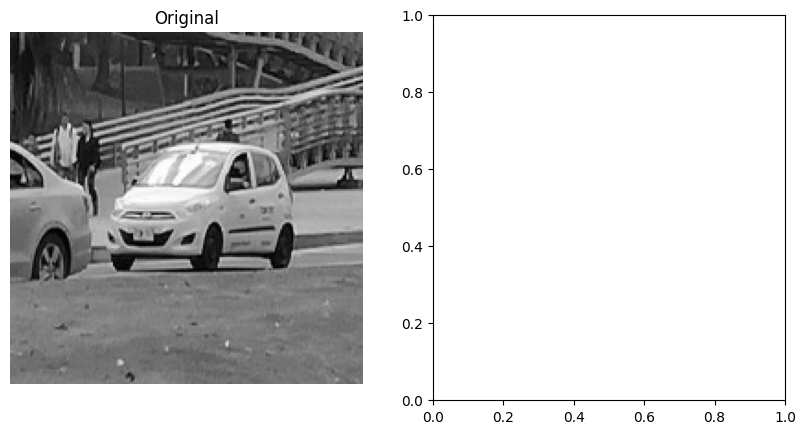

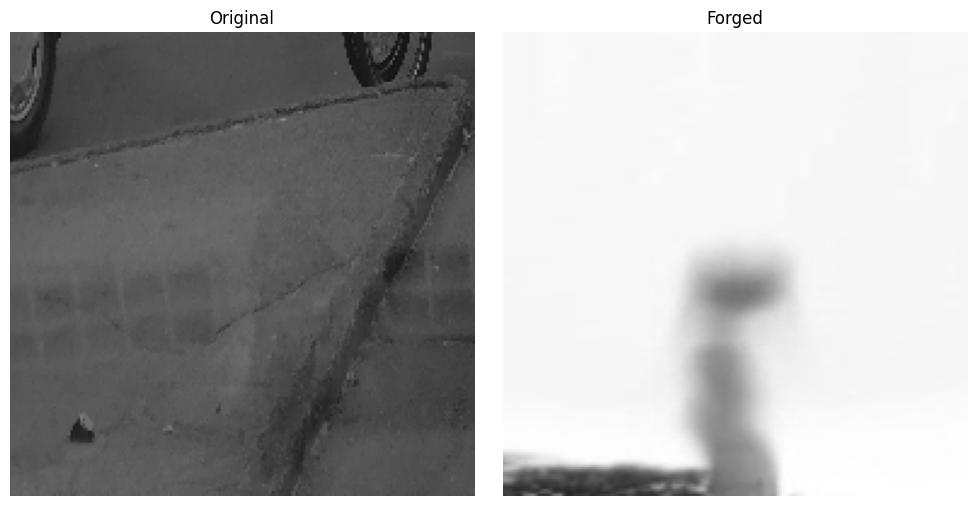

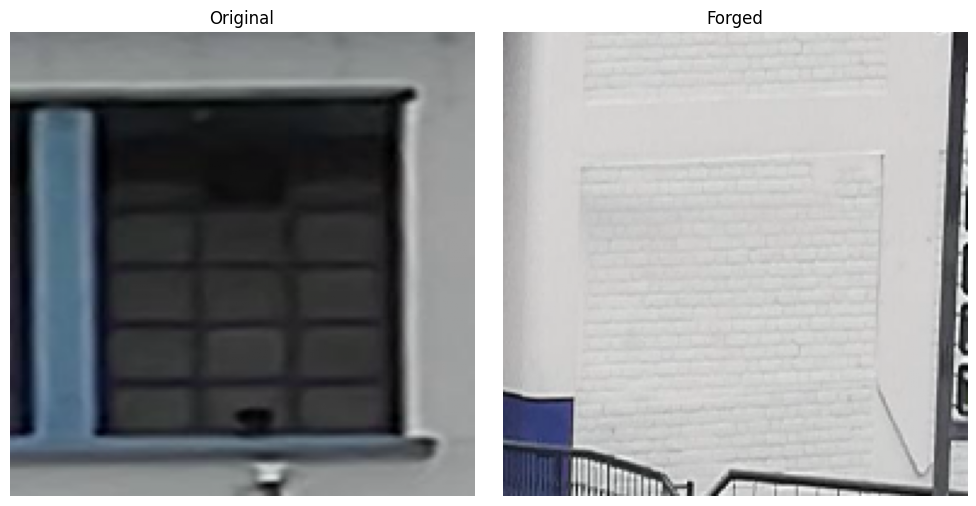

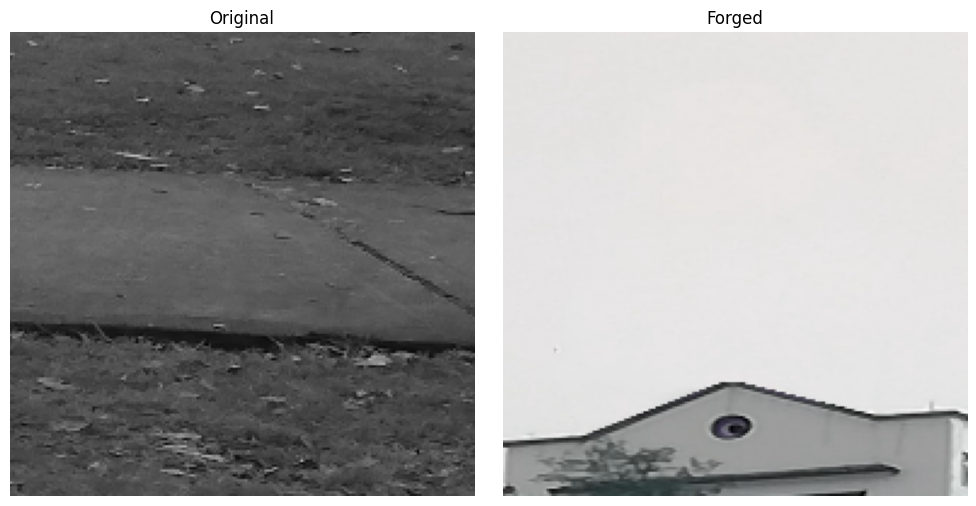

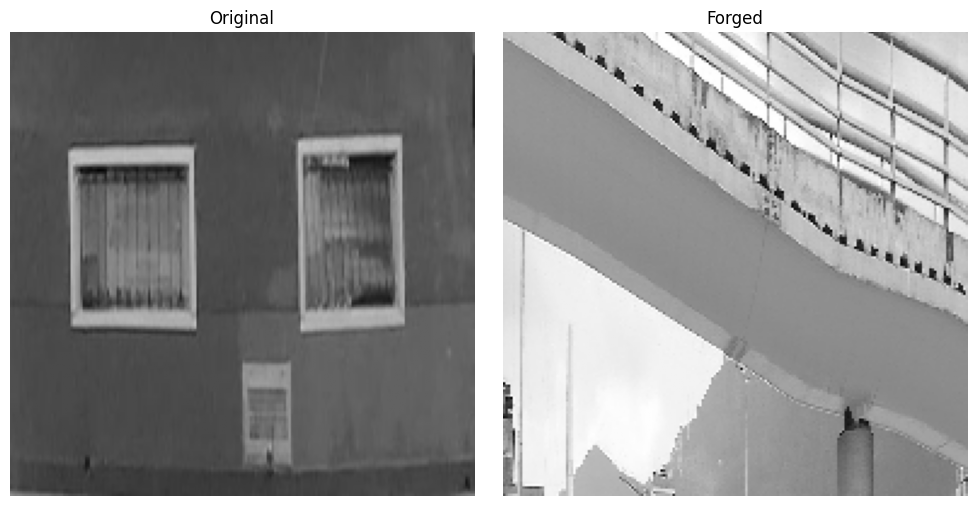

In [65]:
# Print some sample inputs
num_samples = 5
sample_indices = np.random.randint(len(X_train), size=num_samples)

for i in sample_indices:
    if i >= len(X_train):
        continue  # Skip iteration if the index is out of bounds
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(X_train[i])
    axes[0].set_title('Original')
    axes[0].axis('off')

    if i >= len(y_val):
        continue  # Skip iteration if the index is out of bounds
    axes[1].imshow(y_val[i])
    axes[1].set_title('Forged')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [66]:
def ssim_loss(y_true, y_pred):
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return 1 - ssim

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float16)
    y_pred = tf.cast(y_pred, tf.float16)
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Create the forgery detection model
model = create_forgery_model(input_shape=(192, 192, 3))
model.compile(optimizer='adam', loss=ssim_loss, metrics=[ssim_metric])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_11 (Functional)           │ (None, 12, 12, 512)         │       1,473,593 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_12 (Functional)           │ (None, 192, 192, 3)         │         448,003 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,921,596 (7.33 MB)

 Trainable params: 1,921,596 (7.33 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (730, 192, 192, 3)
y_train shape: (730, 192, 192, 3)


In [68]:
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_val shape: (314, 192, 192, 3)
y_val shape: (314, 192, 192, 3)


In [69]:
#checkpoint filepath
checkpoint_filepath = 'model_checkpoint_CG1050.keras'

#checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, save_weights_only=False,
                             save_best_only=True, monitor='ssim_metric', mode='max')

In [70]:
#image data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#training data generator
train_generator = datagen.flow(X_train, y_train, batch_size=8)

In [76]:
# Train the model with the checkpoint callback
history = model.fit(train_generator, batch_size=16, epochs=10, callbacks=[checkpoint], verbose= True)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.4981 - ssim_metric: 0.5019
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.4905 - ssim_metric: 0.5095
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4738 - ssim_metric: 0.5262
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.4895 - ssim_metric: 0.5105
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.4909 - ssim_metric: 0.5091
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.4856 - ssim_metric: 0.5144
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.4779 - ssim_metric: 0.5221
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.4802 - ssim_metric: 0.5198
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.4914 - ssim_metric: 0.5086
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.4718 - ssim_metric: 0.5282


In [86]:
model.save("image_forgery.keras")

In [87]:
# Create image data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create testing data generator
test_generator = datagen.flow(X_val, y_val, batch_size=16)

# Perform predictions on the testing set
predictions = model.predict(test_generator)

# Compute Intersection over Union (IOU)
iou = tf.keras.metrics.MeanIoU(num_classes=2)
iou.update_state(y_val, predictions)
iou_result = iou.result().numpy()
print("IOU:", iou_result)

# Compute Dice coefficient
dice_coefficient = (2 * iou_result) / (iou_result + 1)
print("Dice Coefficient:", dice_coefficient)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step
IOU: 0.48511553
Dice Coefficient: 0.6533034217548619


## **Conclusion and Insights**
This project demonstrates the complexities and challenges inherent in detecting image forgeries using deep learning techniques. Our model achieved an SSIM of approximately 52%, which, although above random guessing, suggests room for significant improvement. This outcome reflects the complexity of distinguishing between subtle image alterations and authentic content, particularly when forgery artifacts may be visually subtle or when the dataset lacks clear distinctions between tampered and original images.

The training loss and SSIM (Structural Similarity Index) metric, plotted across epochs, show some fluctuation, indicating that the model has struggled to converge on a stable solution. This could be due to several factors, including the need for more balanced or diverse data, model architecture adjustments, or further hyperparameter tuning. The model’s tendency to misclassify or produce zero precision and recall suggests it may be biased toward the majority class (i.e., original images), a common issue in datasets with class imbalance.

Next Steps
- Improving Data Balance: Ensuring an even distribution of original and tampered images or applying techniques like class weighting could help the model better generalize across both classes.

- Experimenting with Model Architectures: A more complex model, or one fine-tuned for image feature extraction, may yield better performance.

- Optimizing Hyperparameters: Adjustments to learning rate, batch size, and threshold values for classification could improve the model's capacity to capture subtle forgery features.

- Applying Additional Metrics: Besides SSIM, including precision, recall, and F1-score in model evaluation provides a clearer view of model performance, especially for the minority class (tampered images).

Ultimately, while the project has highlighted some challenges, it also underscores the potential of deep learning for image forgery detection. With further refinements, such a model could become a valuable tool for identifying manipulated images in real-world applications, ranging from digital forensics to media verification.